## NEP_Prediction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots
import sys
from ase.calculators.mixing import SumCalculator
from ase.io import read, iread
from calorine.calculators import CPUNEP
from dftd3.ase import DFTD3
from scipy.stats import norm

plt.style.use(['science','ieee','no-latex','bright'])
plt.rcParams.update({
    'font.size': 14,
    'axes.linewidth': 1,
    'axes.unicode_minus': False,
    'xtick.direction': 'in',
    'ytick.direction': 'in'
})

def nep_calculator(filename="../nep_NequIP.txt", use_dftd3=False):
    if os.path.exists(filename):
        if use_dftd3:
            return SumCalculator([CPUNEP(filename), DFTD3(method="pbe", damping="d3bj")])
        return CPUNEP(filename)
    print(f"File {filename} does not exist.")
    sys.exit(1)
    
def extract_energy_per_atom_from_xyz(file_path):
    energy_per_atom_list = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
    i = 0
    while i < len(lines):
        num_atoms = int(lines[i].strip())
        i += 1
        if "energy=" in lines[i]:
            energy_line = lines[i]
            energy_value = float(energy_line.split("energy=")[1].split()[0])
            energy_per_atom = energy_value / num_atoms
            energy_per_atom_list.append(energy_per_atom)
        i += num_atoms + 1
    return energy_per_atom_list

def energy_prediction(file_path):
    dft = extract_energy_per_atom_from_xyz(file_path)
    frames = read(file_path, index=':')
    nep = []
    for atoms in frames:
        s = atoms.copy()
        s.calc = nep_calculator()
        nep.append(s.get_potential_energy() / len(s))
        
    delta = np.mean(dft) - np.mean(nep) 
    nep = nep + delta
    return np.array(dft), np.array(nep)

def force_prediction(file_path):
    dft, nep = [], []
    for atoms in iread(file_path):
        dft_forces = atoms.get_forces()
        dft.append(dft_forces)
        atoms.calc = nep_calculator()
        nep_forces = atoms.get_forces()
        nep.append(nep_forces)
    dft_array = np.concatenate([f.reshape(-1, 3) for f in dft], axis=0)
    nep_array = np.concatenate([f.reshape(-1, 3) for f in nep], axis=0)
    return dft_array, nep_array

def plot_rmse_error(ax, true_values, predicted_values, label, **kwargs):
    if isinstance(label, (list, tuple)):
        label_str = '_'.join(str(l) for l in label)
    else:
        label_str = str(label)
    errors = predicted_values - true_values
    rmse = np.sqrt(np.mean(errors**2))
    ax.plot(true_values, predicted_values, 'o', label=f'$RMSE_{{{label_str}}}$ = {rmse:.4f}', **kwargs)
    
def plot_identity_line(ax, xlabel, ylabel):
    """Adds an identity line (y=x) to the given axes and sets labels."""
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lmin = min(xmin, ymin)
    lmax = max(xmax, ymax)
    ax.plot([lmin, lmax], [lmin, lmax], c="black", lw=1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim([lmin, lmax])
    ax.set_ylim([lmin, lmax])
    ax.legend(loc="best", fontsize=12)
    
def plot_energy_and_force_comparison(file_path, save_path='./prediction.png'):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    ax1 = plt.gca()
    dft_energy, nep_energy = energy_prediction(file_path)
    plot_rmse_error(ax1, dft_energy, nep_energy, label='GST', color="#EECA40", ms=5)
    plot_identity_line(ax1, 'DFT energy (eV/atom)', 'NEP energy (eV/atom)')

    plt.subplot(1, 2, 2)
    ax2 = plt.gca()
    dft_force, nep_force = force_prediction(file_path)
    directions = ['x', 'y', 'z']
    for i, direction in enumerate(directions):
        plot_rmse_error(ax2, dft_force[:, i], nep_force[:, i], label=direction, ms=5)
    plot_identity_line(ax2, r'DFT force (eV/$\rm{\AA}$)', r'NEP force (eV/$\rm{\AA}$)')

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')


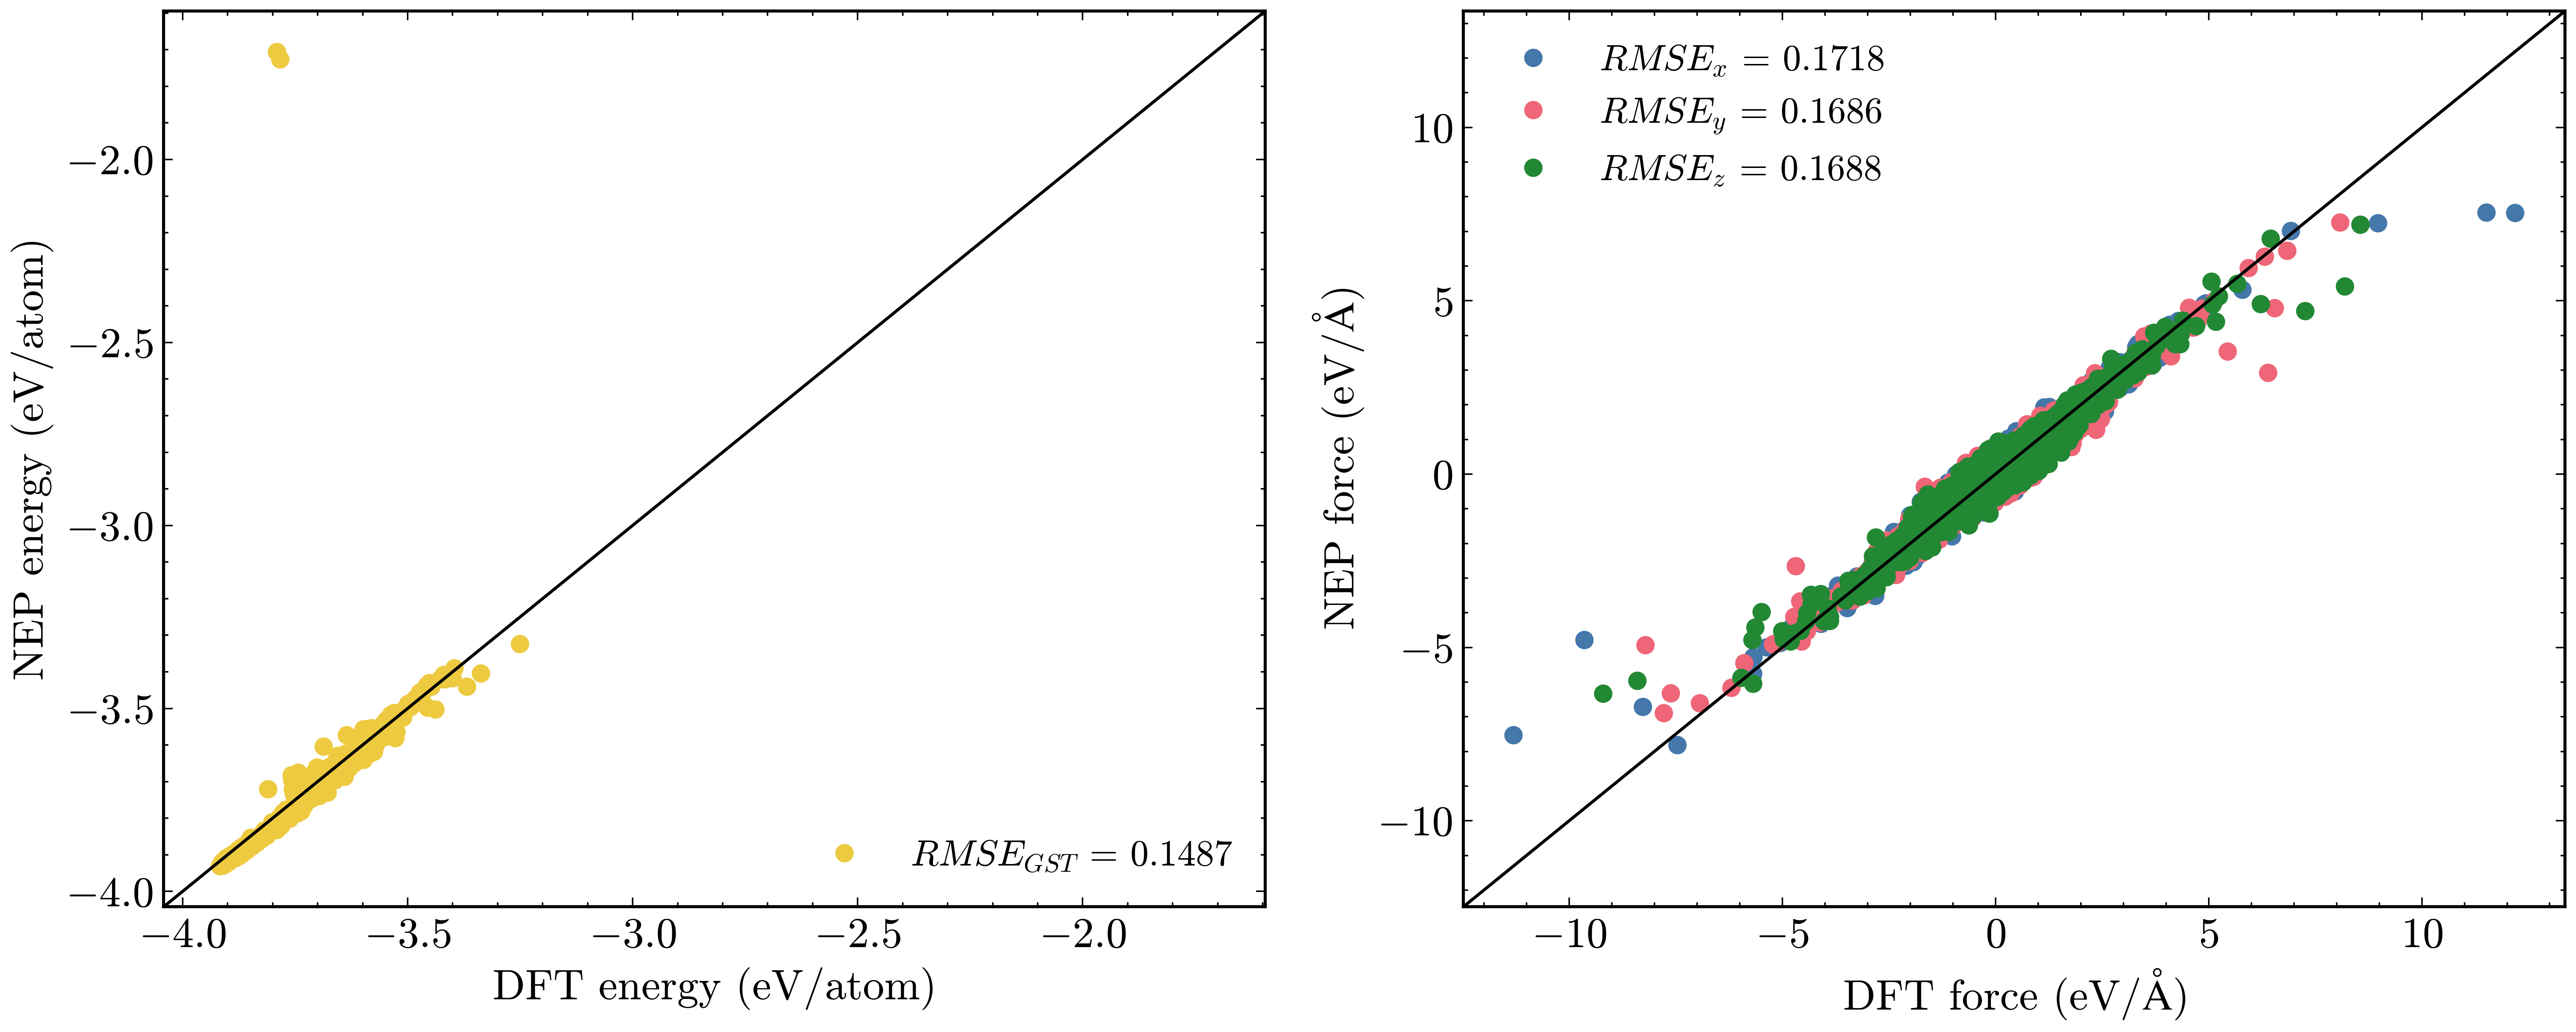

In [2]:
file_path = "./GST.xyz"
plot_energy_and_force_comparison(file_path, save_path='./prediction.png')